In [28]:
import sys
sys.path.append('../src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_data, calculate_returns
from covariance import sample_cov
from portfolio import min_var_weights, portfolio_variance, portfolio_returns

# Load diverse assets
tickers = ['SPY', 'TLT', 'GLD', 'GSG']  # Stocks, Bonds, Gold, Commodities
prices = load_data(tickers, '2007-01-01', '2023-12-31')

print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

[*********************100%***********************]  4 of 4 completed

Data shape: (4278, 4)
Date range: 2007-01-03 00:00:00 to 2023-12-29 00:00:00


# Split into test and train

In [29]:
start_date = '2007-01-01'  
train_end = '2018-12-31'   
test_start = '2019-01-01'  
end_date = '2023-12-31'

# Calculate returns

In [30]:
returns = calculate_returns(prices)
# Split into train and test sets


# Doing the calculations

In [31]:
# Calculate returns
returns = calculate_returns(prices)

# Split into train and test sets
train_returns = returns.loc[start_date:train_end]
test_returns = returns.loc[test_start:end_date]

# Calculate sample covariance matrix ON TRAINING DATA
train_cov_matrix = sample_cov(train_returns)

# Calculate minimum variance weights USING TRAINING DATA
weights = min_var_weights(train_cov_matrix)

# Calculate portfolio performance ON TEST DATA (out-of-sample)
test_port_returns = portfolio_returns(weights, test_returns)  # <-- Changed variable name!

# Also calculate training performance if you want to compare
train_port_returns = portfolio_returns(weights, train_returns)

print(f"Minimum variance weights: {weights}")
print(f"Portfolio variance (training): {portfolio_variance(weights, train_cov_matrix):.4f}")
print(f"Portfolio volatility (training): {np.sqrt(portfolio_variance(weights, train_cov_matrix)):.2%}")

Minimum variance weights: [0.10804302 0.0812371  0.29126584 0.51945404]
Portfolio variance (training): 0.0067
Portfolio volatility (training): 8.20%


Text(0.5, 1.0, 'Performance Summary (Test Period)')

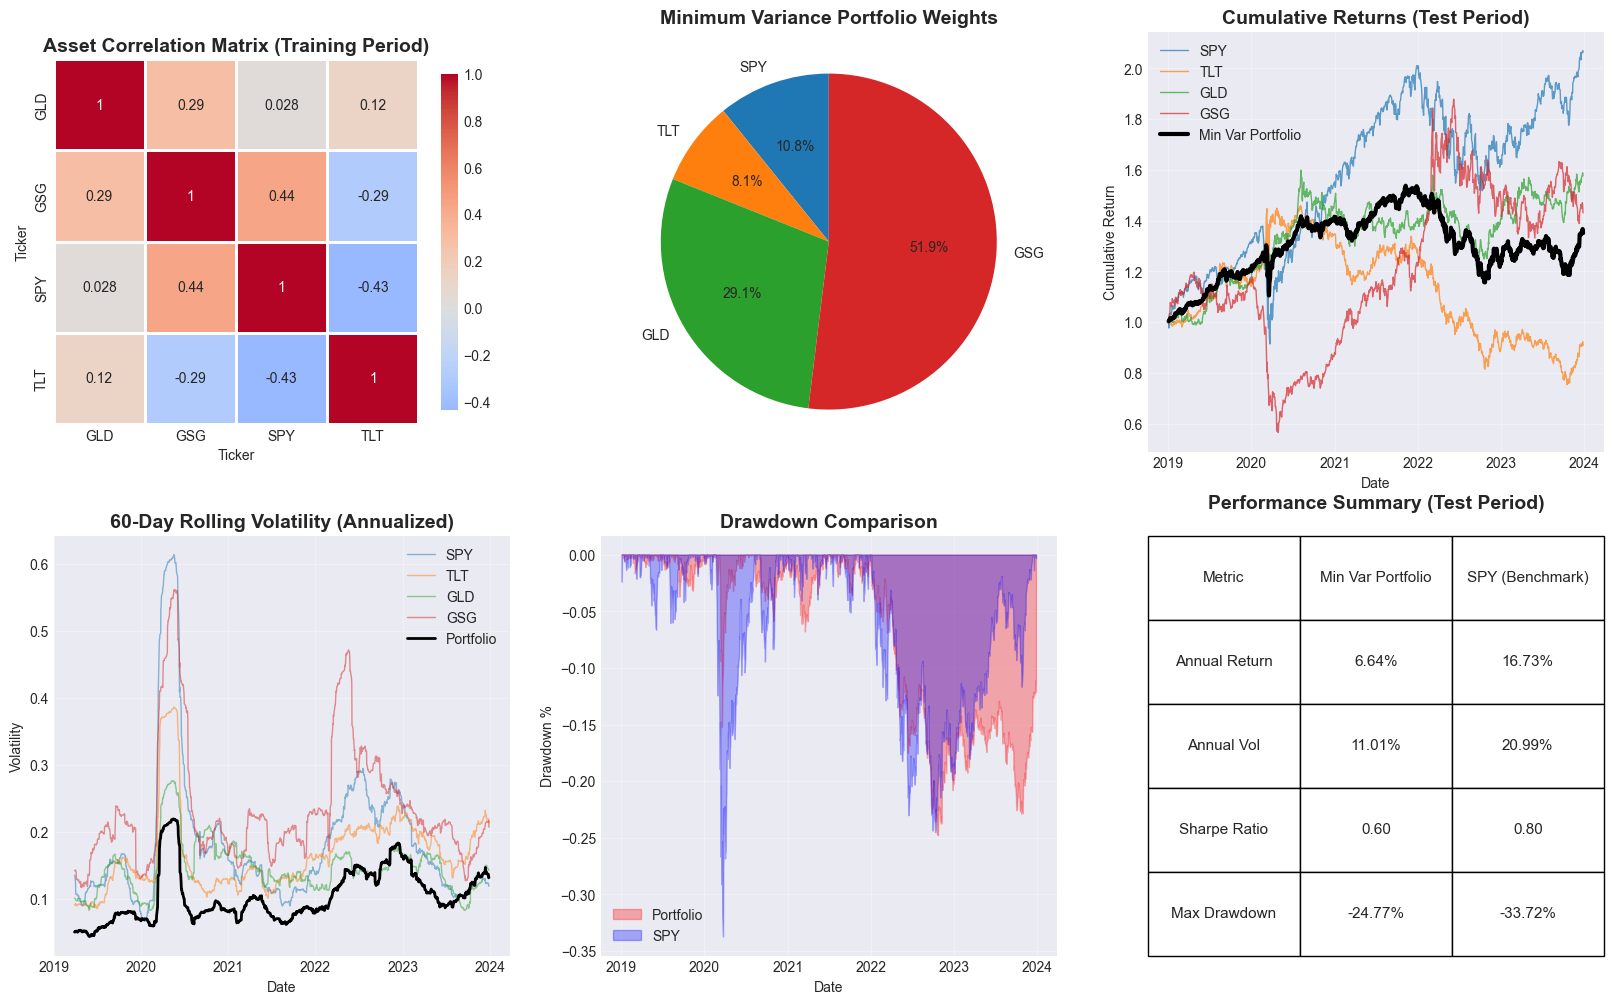

In [32]:
# Set style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 12))

# 1. Correlation Heatmap
plt.subplot(2, 3, 1)
corr_matrix = train_returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Asset Correlation Matrix (Training Period)', fontsize=14, fontweight='bold')

# 2. Portfolio Weights
plt.subplot(2, 3, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.pie(weights, labels=tickers, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Minimum Variance Portfolio Weights', fontsize=14, fontweight='bold')

# 3. Cumulative Returns Comparison
plt.subplot(2, 3, 3)
# Calculate cumulative returns
test_cumulative = (1 + test_returns).cumprod()
port_cumulative = (1 + test_port_returns).cumprod()

# Plot individual assets
for ticker in tickers:
    plt.plot(test_cumulative.index, test_cumulative[ticker], 
             label=ticker, alpha=0.7, linewidth=1)

# Plot portfolio
plt.plot(port_cumulative.index, port_cumulative, 
         label='Min Var Portfolio', color='black', linewidth=3)

plt.title('Cumulative Returns (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Rolling Volatility
plt.subplot(2, 3, 4)
rolling_window = 60  # 60 days
rolling_vols = test_returns.rolling(rolling_window).std() * np.sqrt(252)
port_rolling_vol = test_port_returns.rolling(rolling_window).std() * np.sqrt(252)

for ticker in tickers:
    plt.plot(rolling_vols.index, rolling_vols[ticker], 
             label=ticker, alpha=0.5, linewidth=1)

plt.plot(port_rolling_vol.index, port_rolling_vol, 
         label='Portfolio', color='black', linewidth=2)

plt.title(f'{rolling_window}-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Drawdown Analysis
plt.subplot(2, 3, 5)
def calculate_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

# Calculate drawdowns
port_drawdown = calculate_drawdown(test_port_returns)
spy_drawdown = calculate_drawdown(test_returns['SPY'])

plt.fill_between(port_drawdown.index, port_drawdown, 0, 
                 alpha=0.3, color='red', label='Portfolio')
plt.fill_between(spy_drawdown.index, spy_drawdown, 0, 
                 alpha=0.3, color='blue', label='SPY')

plt.title('Drawdown Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Drawdown %')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Performance Summary Table
plt.subplot(2, 3, 6)
plt.axis('off')

# Calculate metrics
def calculate_metrics(returns):
    annual_return = returns.mean() * 252
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol
    max_dd = calculate_drawdown(returns).min()
    return {
        'Annual Return': f'{annual_return:.2%}',
        'Annual Vol': f'{annual_vol:.2%}',
        'Sharpe Ratio': f'{sharpe:.2f}',
        'Max Drawdown': f'{max_dd:.2%}'
    }

# Create metrics for portfolio and SPY
port_metrics = calculate_metrics(test_port_returns)
spy_metrics = calculate_metrics(test_returns['SPY'])

# Create table data
metrics_data = [
    ['Annual Return', port_metrics['Annual Return'], spy_metrics['Annual Return']],
    ['Annual Vol', port_metrics['Annual Vol'], spy_metrics['Annual Vol']],
    ['Sharpe Ratio', port_metrics['Sharpe Ratio'], spy_metrics['Sharpe Ratio']],
    ['Max Drawdown', port_metrics['Max Drawdown'], spy_metrics['Max Drawdown']]
]

# Create table with simpler approach
table = plt.table(cellText=metrics_data,
                 colLabels=['Metric', 'Min Var Portfolio', 'SPY (Benchmark)'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title('Performance Summary (Test Period)', fontsize=14, fontweight='bold', pad=20)